https://www.kaggle.com/datasets/umerrtx/machine-failure-prediction-using-sensor-data/data

https://www.kaggle.com/datasets/rabieelkharoua/predicting-manufacturing-defects-dataset

https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

https://www.kaggle.com/datasets/wolfmedal/aero-engine-defect-new

### Dataset:
Casting product image data for quality inspection (https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

'''Discuss some background ......'''

---
### Step 1: Import libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

def reset_seeds(seed_val = 1234):
   np.random.seed(seed_val)
   random.seed(seed_val)
   tf.random.set_seed(seed_val)
    
reset_seeds()

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

---
### Step 2: Data ingestion

Loading the 2D images and their corresponding labels.

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    '''
    ## load images and labels
    # FILL IN CODE HERE #  

    images = []
    labels = []

    for folder_name in os.listdir(path_to_data): 
        if folder_name != '.DS_Store': 
            folder_path = os.path.join(path_to_data, folder_name)
        
            for file_name in os.listdir(folder_path): 
                image_path = os.path.join(folder_path, file_name)
                image = load_img(image_path)
                image_arr = img_to_array(image)
                images.append(image_arr)
                labels.append(folder_name)
    
    return np.array(images), np.array(labels)

In [3]:
# Data Paths
path_to_data_train = r'C:\Users\silve\OneDrive\Documents\207\project\data\casting_data\casting_data\train'
path_to_data_test = r'C:\Users\silve\OneDrive\Documents\207\project\data\casting_data\casting_data\test'

# Train/Test Data
x_train, y_train = load_data(path_to_data_train)




In [4]:
x_test, y_test = load_data(path_to_data_test)

In [5]:
# Output shapes to check loading
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (6633, 300, 300, 3)
y_train shape: (6633,)
x_test shape: (715, 300, 300, 3)
y_test shape: (715,)


[Text(0.5, 1.0, 'Training Data Class Distribution')]

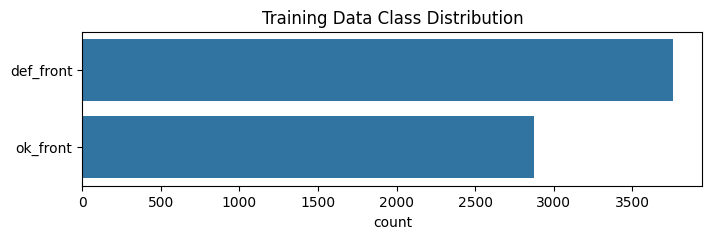

In [6]:
# Review Class Distribution
# if y_train.dtype == 'object':
#     y_train = y_train.astype('category')
y_train = pd.Series(y_train)
    
plt.figure(figsize=(8,2))
sns.countplot(y_train).set(title='Training Data Class Distribution')

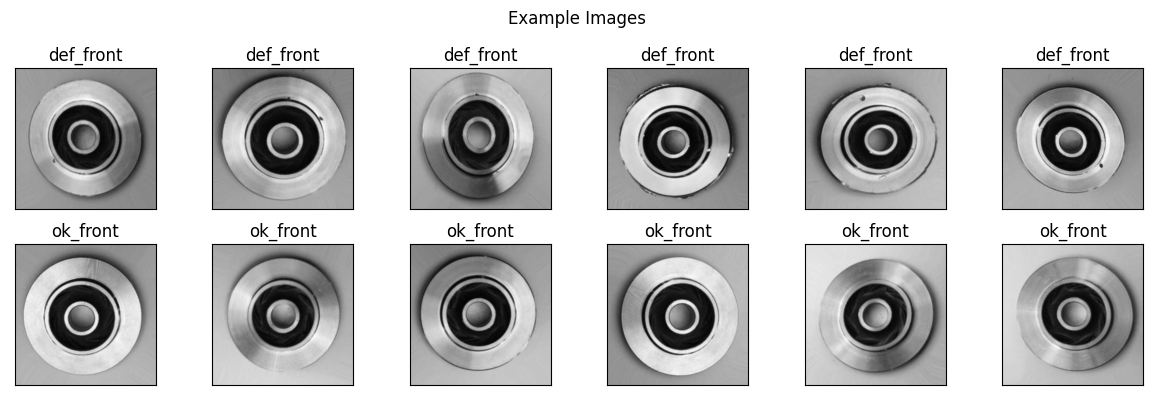

In [7]:
# Display Examples
image_dict = {}
dict_counter = 0
num_row = 2
num_col = 6
i = 0

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
plt.suptitle('Example Images')

for ima, lab in zip(x_train, y_train): 
    if i > num_row*num_col:   # prevent from script from having to go through all training examples
        break

    if lab not in image_dict.keys():
        image_dict[lab] = [ima]

        ax = axes[i//num_col, i%num_col]
        ax.imshow(ima.astype('uint8'))
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(lab)
        i += 1

    elif len(image_dict[lab]) < num_col: 
        image_dict[lab].append(ima)

        ax = axes[i//num_col, i%num_col]
        ax.imshow(ima.astype('uint8'))
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(lab)
        i += 1
        # print(i)
        
    else:
        continue

plt.tight_layout()
plt.show()

In [8]:
# Set Classes to 1 for defective parts and 0 for non-defective parts

'''Use one hot encoding.  '''
y_train[y_train=='def_front'] = 1
y_train[y_train=='ok_front'] = 0
y_train = y_train.astype('int')

y_test[y_test=='def_front'] = 1
y_test[y_test=='ok_front'] = 0
y_test = y_test.astype('int')
# print(y_train, y_test)

In [9]:
# Shuffle x_train 
reset_seeds()

shuffle = np.random.permutation(np.arange(y_train.shape[0]))
x_train, y_train = x_train[shuffle], y_train[shuffle]

### Baseline Prediction 

In [10]:
# Use majority classa
y_pred = np.ones(len(y_test))
baseline_accuracy = np.sum(y_test==y_pred)/len(y_test)

print(f'Baseline Accuracy using Majority Class (Defective): {100*baseline_accuracy: .2f}%')

Baseline Accuracy using Majority Class (Defective):  63.36%


In [34]:
print(baseline_accuracy)

0.6335664335664336


# Preprocessing

In [11]:
train_acc = 0.6336
val_acc = 0.6336

In [12]:
def accuracies(model, x_train, x_val, y_train, y_val):
    y_train_pred = model.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_val_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    return train_accuracy, val_accuracy

In [13]:
from sklearn.model_selection import train_test_split

x_train_s, x_val, y_train_s, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [14]:
y_test = pd.Series(y_test)

# NN

In [15]:
x_train_p = x_train_s / 255
x_test_p = x_test / 255

In [16]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # YOUR CODE HERE
    model = tf.keras.Sequential()
    # Set input shape in advance
    model.add(tf.keras.Input(shape=(300,300,3), name='Input'))
    model.add(tf.keras.layers.Flatten(name='Flatten'))
    
    i = 1
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation,
                                        name=('Hidden' + str(i))))
        i += 1
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax', name='Output'))

    if optimizer == 'SGD':
        optimizer_param = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer_param = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=optimizer_param, metrics = [metric])

    return model

In [17]:
np.random.seed(0)
tf.random.set_seed(0)

In [18]:
def train_and_evaluate(
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=20):

  # Build the model.
    model = build_model(n_classes=2,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)


  # Train the model.
    print('Training the model...')
    history = model.fit(
        x=x_train_p,
        y=y_train_s,
        epochs=num_epochs,
        batch_size=32,
        validation_data=(x_val, y_val),
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model, train_accuracy[-1], val_accuracy[-1]




Training the model...


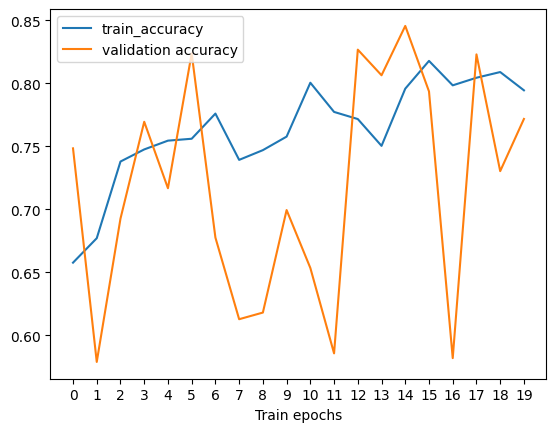

Training accuracy: 0.7944
Validation accuracy: 0.7717


In [20]:
nn_model, nn_train_a, val_a = train_and_evaluate()

In [38]:
nn_model.evaluate(x_test_p, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9187 - loss: 8.7653   


[24.450824737548828, 0.8069930076599121]

0
Size:  []
Activation:  tanh
Optimizer:  SGD
Training the model...


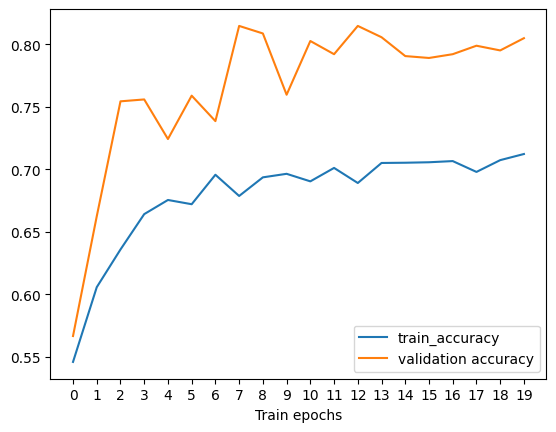

Training accuracy: 0.7122
Validation accuracy: 0.8048
1
Size:  []
Activation:  tanh
Optimizer:  Adam
Training the model...


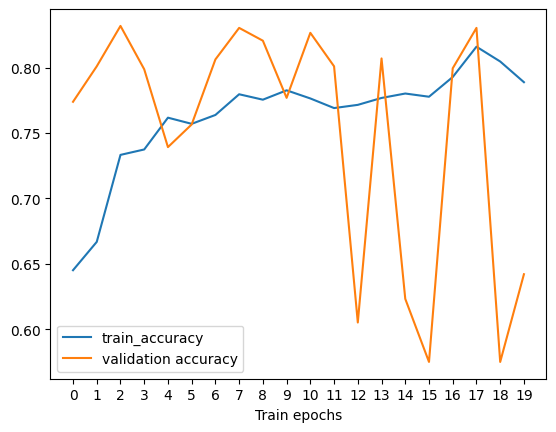

Training accuracy: 0.7889
Validation accuracy: 0.6420
0
Size:  []
Activation:  relu
Optimizer:  SGD
Training the model...


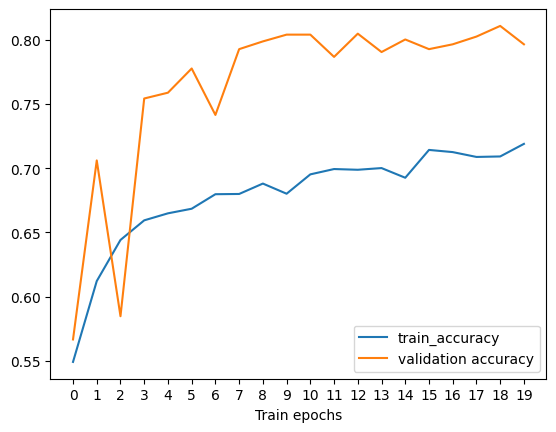

Training accuracy: 0.7190
Validation accuracy: 0.7965
1
Size:  []
Activation:  relu
Optimizer:  Adam
Training the model...


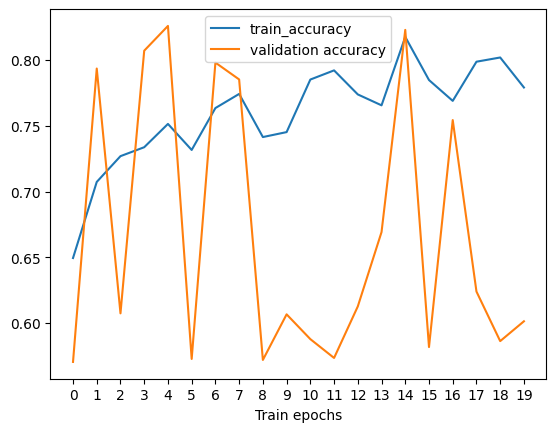

Training accuracy: 0.7791
Validation accuracy: 0.6014
0
Size:  [128]
Activation:  tanh
Optimizer:  SGD
Training the model...


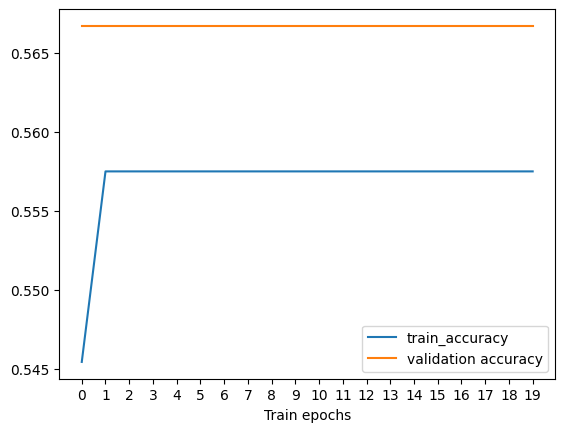

Training accuracy: 0.5575
Validation accuracy: 0.5667
1
Size:  [128]
Activation:  tanh
Optimizer:  Adam
Training the model...


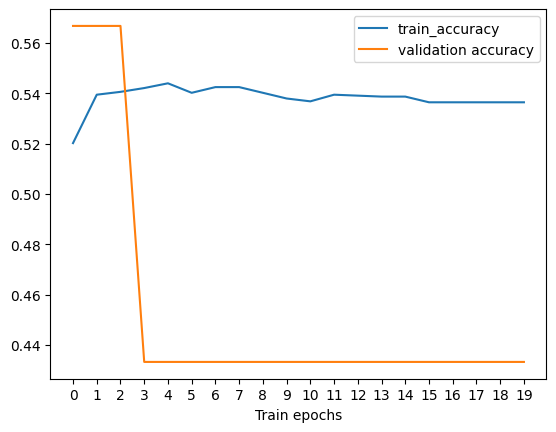

Training accuracy: 0.5364
Validation accuracy: 0.4333
0
Size:  [128]
Activation:  relu
Optimizer:  SGD
Training the model...


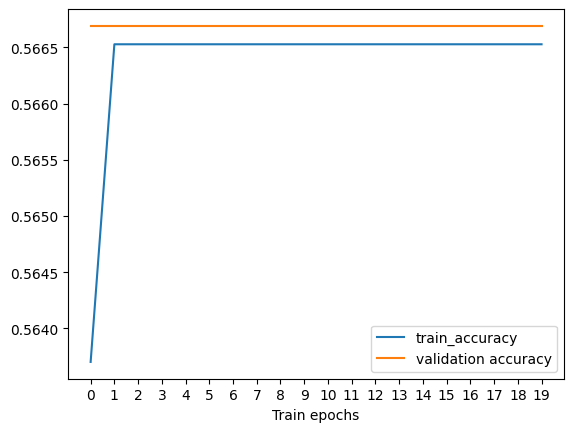

Training accuracy: 0.5665
Validation accuracy: 0.5667
1
Size:  [128]
Activation:  relu
Optimizer:  Adam
Training the model...


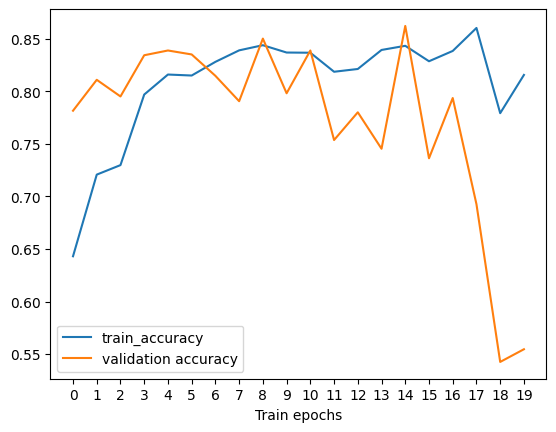

Training accuracy: 0.8155
Validation accuracy: 0.5546
0
Size:  [256, 128]
Activation:  tanh
Optimizer:  SGD
Training the model...


KeyboardInterrupt: 

In [39]:
# YOUR CODE HERE
hidden_sizes = [[], [128], [256,128]]
activations = ['tanh', 'relu']
optimizers = ['SGD', 'Adam']

tf.random.set_seed(0)

#from baseline
best_train_a = 0.633
best_val_a = 0.633
best_parameters = {}

for idx, size in enumerate(hidden_sizes):
    for idx, act in enumerate(activations):
        for idx, opt in enumerate(optimizers):

            print(idx)
            
            print("Size: ", size)
            print("Activation: ", act)
            print("Optimizer: ", opt)
            model, train_a, val_a = train_and_evaluate(hidden_layer_sizes= size, activation= act, optimizer=opt)
            if val_a > best_val_a:
                best_train_a = train_a
                best_val_a = val_a
                best_parameters = {'size': size, 'activation': act, 'optimizer': opt}
                best_model = model

print("Training Accuracy: ", best_train_a)
print("Validation Accuracy: ", best_val_a)


Training the model...


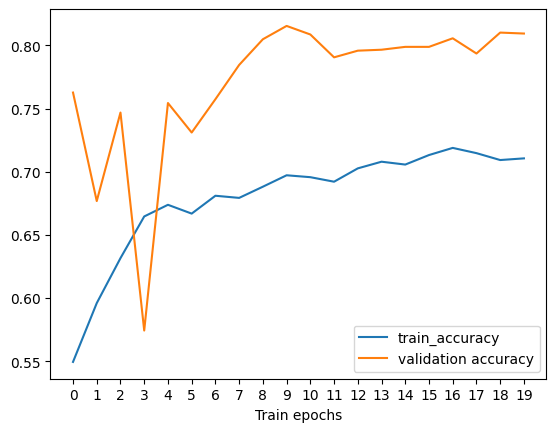

Training accuracy: 0.7105
Validation accuracy: 0.8093


In [19]:
nn_model, nn_train_a, val_a = train_and_evaluate(hidden_layer_sizes=[], activation='tanh', optimizer='SGD')

0
Learning Rate 0.01
Training the model...


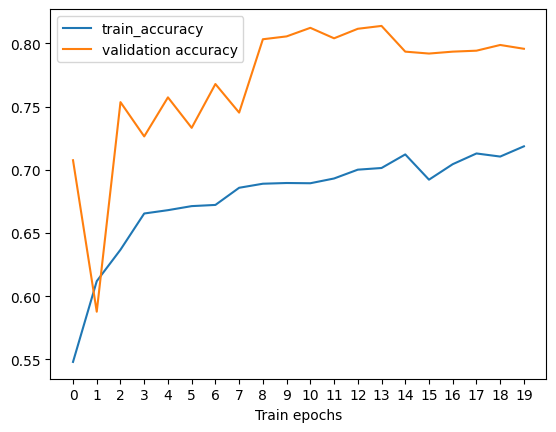

Training accuracy: 0.7186
Validation accuracy: 0.7958
1
Learning Rate 0.001
Training the model...


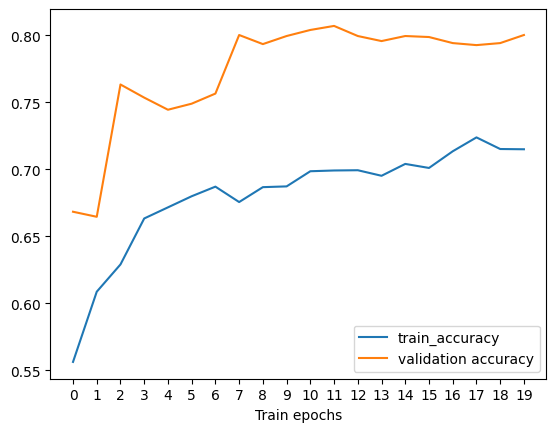

Training accuracy: 0.7150
Validation accuracy: 0.8003
2
Learning Rate 0.0001
Training the model...


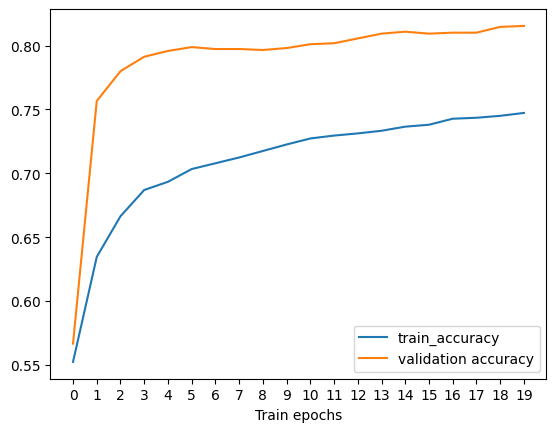

Training accuracy: 0.7473
Validation accuracy: 0.8154
Training Accuracy:  0.7472672462463379
Validation Accuracy:  0.8153730034828186


In [23]:
learning_rates = [0.01, 0.001, 0.0001]

tf.random.set_seed(0)

#from baseline
best_train_a = 0.633
best_val_a = 0.633

for idx, lr in enumerate(learning_rates):
            print(idx)
            print("Learning Rate", lr)
            model, train_a, val_a = train_and_evaluate(hidden_layer_sizes= [], activation= 'tanh', optimizer='SGD', learning_rate = lr)
            if val_a > best_val_a:
                best_train_a = train_a
                best_val_a = val_a
                best_model = model

print("Training Accuracy: ", best_train_a)
print("Validation Accuracy: ", best_val_a)

In [24]:
best_model.evaluate(x_train_p, y_train_s)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8237 - loss: 0.3968


[0.39992931485176086, 0.8243498206138611]

In [25]:
best_model.evaluate(x_test_p, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8246 - loss: 0.3370


[0.4249155819416046, 0.788811206817627]

Size:  []
Activation:  tanh
Optimizer:  SGD
Learning Rate: 0.0001

# Decision Tree

In [29]:
# compute number of features (multiply RGB features)
#features_shape = x_train_s[:, :, :, 0].shape[1] * x_train_s.shape[2] * x_train_s.shape[3]
# features_shape = (x_train.shape[0], -1)  # -1 infers the size of the second dimension
# print('Total number of features used for Decision Forests', features_shape)

# reshape data

X_train_re = x_train_s.reshape((x_train_s.shape[0], -1))
X_val_re = x_val.reshape((x_val.shape[0], -1))
X_test_re = x_test.reshape((x_test.shape[0], -1))

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Shape of train images  (5306, 270000)
Shape of train labels  (6633,)
Shape of val images  (1327, 270000)
Shape of test images  (715, 270000)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimators= [4, 6, 8]
jobs = [1,3,5]
depths = [10, 12, 14] 

tf.random.set_seed(0)
best_model = None

for idx, estimator in enumerate(estimators):
    for idx, job in enumerate(jobs):
        for idx, depth in enumerate(depths):            
            rf_clf = RandomForestClassifier(n_estimators=estimator,n_jobs=job, random_state=0,max_depth=depth)
            rf_clf.fit(X_train_re, y_train_s)
            train_a, val_a = accuracies(rf_clf, X_train_re, X_val_re, y_train_s, y_val)
            print(idx, ": ", train_a, val_a)
            if train_a > train_acc and val_a > val_acc:
                best_model = rf_clf
                train_acc = train_a
                val_acc = val_a
                print("Estimators: ", estimator)
                print("Jobs: ", job)
                print("Depths: ", depth)


0 :  0.9704108556351301 0.9419743782969103
Estimators:  4
Jobs:  1
Depths:  10
1 :  0.977761025254429 0.9321778447626224
2 :  0.9802110817941952 0.9291635267520724
0 :  0.9704108556351301 0.9419743782969103
1 :  0.977761025254429 0.9321778447626224
2 :  0.9802110817941952 0.9291635267520724
0 :  0.9704108556351301 0.9419743782969103
1 :  0.977761025254429 0.9321778447626224
2 :  0.9802110817941952 0.9291635267520724
0 :  0.9787033546928006 0.9434815373021854
Estimators:  6
Jobs:  1
Depths:  10
1 :  0.9845457972107049 0.9382064807837227
2 :  0.9858650584244252 0.9382064807837227
0 :  0.9787033546928006 0.9434815373021854
1 :  0.9845457972107049 0.9382064807837227
2 :  0.9858650584244252 0.9382064807837227
0 :  0.9787033546928006 0.9434815373021854
1 :  0.9845457972107049 0.9382064807837227
2 :  0.9858650584244252 0.9382064807837227
0 :  0.9792687523558236 0.9434815373021854
1 :  0.9860535243120995 0.9502637528259231
Estimators:  8
Jobs:  1
Depths:  12
2 :  0.9888805126272144 0.941220798

Validation Accuracy:  0.9502637528259231


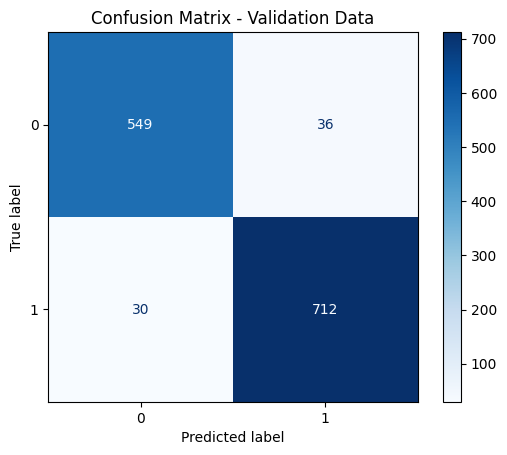

In [ ]:
## YOUR CODE HERE ###
y_val_pred = best_model.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)
print('Validation Accuracy: ', val_accuracy)

cmatrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

Test Accuracy:  0.958041958041958


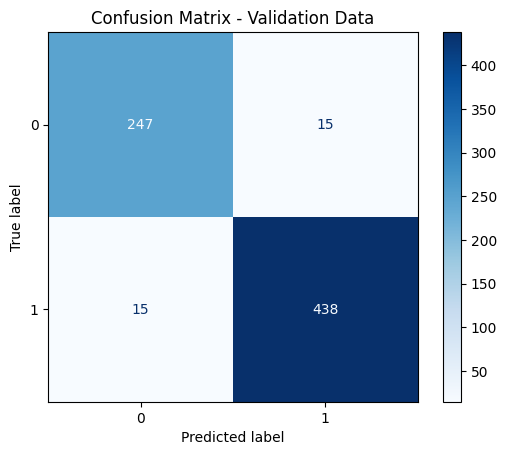

In [ ]:
## YOUR CODE HERE ###
y_pred = best_model.predict(X_test_re)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy: ', test_accuracy)

cmatrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Logistic Regression

In [31]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=2,        # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='relu',
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, metrics=['accuracy'], loss = loss_fn)
    
  return model

In [32]:
tf.random.set_seed(0)

model_tf = build_model(
            num_features=X_train_re.shape[1],
            learning_rate=0.0001
        )

history = model_tf.fit(X_train_re,
                    y_train_s,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val_re, y_val))

c:\Users\silve\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.5354 - loss: 121040.0547 - val_accuracy: 0.7506 - val_loss: 17601.2207
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6081 - loss: 76260.1875 - val_accuracy: 0.6858 - val_loss: 33924.4805
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6147 - loss: 73714.1328 - val_accuracy: 0.7573 - val_loss: 26972.4590
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6693 - loss: 53150.9336 - val_accuracy: 0.7362 - val_loss: 31315.0391
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6902 - loss: 47062.1836 - val_accuracy: 0.7558 - val_loss: 27271.7559


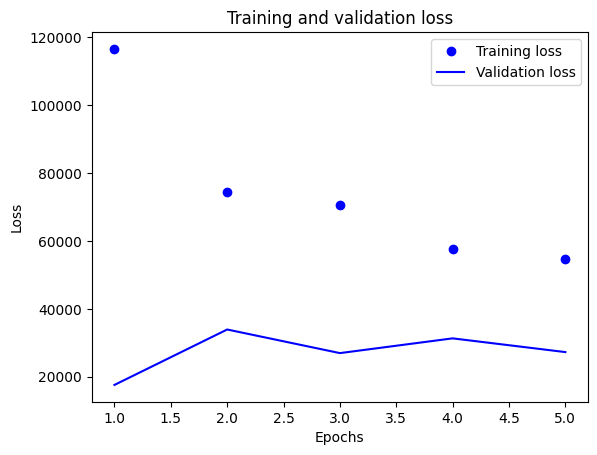

In [33]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [36]:
tf.random.set_seed(0)

# define learning rates
learning_rates = [0.0001, 0.1]
epochs = [5, 15]
batch_size = [32, 64]

for idx, eta in enumerate(learning_rates):
    for idx, epoch_num in enumerate(epochs):
        for idx, batch_num in enumerate(batch_size):
            
            # (1) Build and compile the baseline model
            model_tf = build_model(
                num_features=X_train_re.shape[1],
                learning_rate=eta
            )
            
            # (2) Fit the model using the train data
            
            history = model_tf.fit(X_train_re,
                                y_train_s,
                                batch_size=batch_num,
                                epochs=epoch_num,
                                validation_data=(X_val_re, y_val),
                                verbose=0)

            
            # (4) Evaluate performance of the model if accuracy is good
            accuracy = history.history['accuracy'][-1]
            if accuracy > baseline_accuracy: # this is the loss of the original
                print('learning_rate:', eta)
                print('epochs:', epoch_num)
                print('batch_size:', batch_num)
                print('---------------------')

                print("Accuracy: ", accuracy)
                print("Val Accuracy ", history.history['val_accuracy'][-1])


c:\Users\silve\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


learning_rate: 0.0001
epochs: 5
batch_size: 32
---------------------
Accuracy:  0.6739540100097656
Val Accuracy  0.7558402419090271
learning_rate: 0.0001
epochs: 5
batch_size: 64
---------------------
Accuracy:  0.6338107585906982
Val Accuracy  0.616428017616272
learning_rate: 0.0001
epochs: 15
batch_size: 32
---------------------
Accuracy:  0.7014700174331665
Val Accuracy  0.8018085956573486
learning_rate: 0.0001
epochs: 15
batch_size: 64
---------------------
Accuracy:  0.6890313029289246
Val Accuracy  0.663903534412384


c:\Users\silve\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


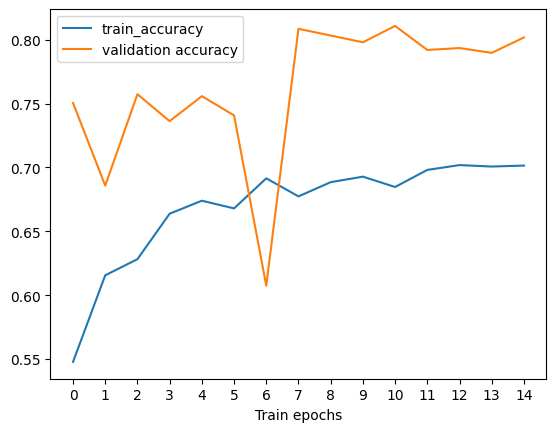

In [37]:
# (1) Build and compile the baseline model
model_tf = build_model(
    num_features=X_train_re.shape[1],
    learning_rate=0.0001
)

# (2) Fit the model using the train data

history = model_tf.fit(X_train_re,
                    y_train_s,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val_re, y_val),
                    verbose=0)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(15))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [38]:
model_tf.evaluate(X_train_re, y_train_s)

166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8043 - loss: 16726.5273


[16980.76171875, 0.8045608997344971]

In [39]:
model_tf.evaluate(X_test_re, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7808 - loss: 17500.6289


[19781.48828125, 0.7748251557350159]

Mean pixel value across all  0  :  149.86723
Mean pixel value across all  1  :  139.2318


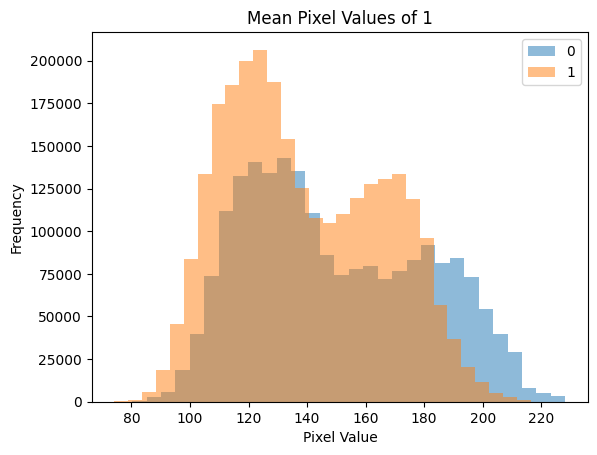

In [40]:
labels = [0,1]
for i in labels:
    labels_indices = np.where(y_train_s == i)[0]
    class_images = x_train_s[labels_indices]
    class_means = class_images.mean(axis=1)

    # creates histogram of distribution of pixels
    # plt.hist(class_means.flatten())
    plt.hist(class_means.flatten(), alpha=0.5, label=str(i), bins=30)
    print("Mean pixel value across all ", str(i), " : ", class_means.mean())

plt.title('Mean Pixel Values of ' + str(i))
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()